In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../scripts')
import util

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# from Yesh's DIF_IP script
from pixval import Formatter
import blob_utils as bu
from enum import IntEnum
from skimage import measure

green = (0, 255, 0)

### Set all the params from Yesh's script

In [2]:

DIF_ImageProcParams = {}
# Imaging settings
DIF_ImageProcParams['timeLapse_us'] = 4    # Time lapse between images for velocity calc
DIF_ImageProcParams['pxSize_um'] = 0.345 ;#0.350
# Image crop bounds and sub-sample step size
DIF_ImageProcParams['frameHeight_px'] = 2160 ;#1040
DIF_ImageProcParams['frameWidth_px'] = 2560 ;#1392
DIF_ImageProcParams['rMin'] = 1028 ;#528 ;#648
DIF_ImageProcParams['rMax'] = 2160 ;#2148
DIF_ImageProcParams['cMin'] = 0
DIF_ImageProcParams['cMax'] = 2560 ;#2548
DIF_ImageProcParams['rStep'] = 1
DIF_ImageProcParams['cStep'] = 1

# Preprocessing params
DIF_ImageProcParams['bg_thresh'] = 30
DIF_ImageProcParams['blurKernelSize'] = int(15/DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['tophatKernalSize'] = int(43/DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['adaptiveMethod'] = cv2.ADAPTIVE_THRESH_GAUSSIAN_C #cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
DIF_ImageProcParams['thresholdType'] = cv2.THRESH_BINARY+cv2.THRESH_OTSU#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV
DIF_ImageProcParams['blockSize'] = 25 #odd number like 3,5,7,9,11
DIF_ImageProcParams['subConst'] = 2 # constant to be subtracted
DIF_ImageProcParams['minThVal'] = 0      # Min and max threshold values
DIF_ImageProcParams['maxThVal'] = 255

# Params for pruning blobs by size, circularity
DIF_ImageProcParams['circTh'] = 0.7
DIF_ImageProcParams['minSzInPx'] = 400/(DIF_ImageProcParams['rStep']*DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['maxSzInPx'] = 1600/(DIF_ImageProcParams['rStep']*DIF_ImageProcParams['rStep'])
# Used to filter out images with no drop (hence too many stray objects) and too many drops
DIF_ImageProcParams['maxDropsPerImg'] = 200

# Line registration params
DIF_ImageProcParams['intraLineSpecPx'] = int(30/DIF_ImageProcParams['cStep'])
DIF_ImageProcParams['maxDiffInMeanForSameLines_px'] = int(20/DIF_ImageProcParams['cStep'])
DIF_ImageProcParams['maxInterDrpToDrpDist_px'] = int(70/DIF_ImageProcParams['rStep'])    # Should be set based on min possible velocity
DIF_ImageProcParams['maxDrpToDrpDistInTime_px'] = int(20/DIF_ImageProcParams['rStep'])

# Dispenser and nozzle settings
DIF_ImageProcParams['nozzSpacing_um'] = 141.1082
DIF_ImageProcParams['phaseIDs'] = [1,2,3]

# Blob registration parameters
DIF_ImageProcParams['blobCorrBBXSzPx'] = 101       ;# Correlation bounding box X size (width)
DIF_ImageProcParams['blobCorrBBYSzPx'] = 101       ;# Correlation bounding box Y size (height)
DIF_ImageProcParams['blobCorrTh'] = 0.95           ;# Blob correlation threshold
DIF_ImageProcParams['xDispPxTh'] = 10              ;# Max X displacement in pixels
DIF_ImageProcParams['yDispPxTh'] = 150             ;# Max Y displacement in pixels
DIF_ImageProcParams['areaDiffTh'] = 100            ;# Max diff in areas of corresponding blobs
DIF_ImageProcParams['majorAxisDiffTh'] = 10        ;# Max diff in major axis lengths of corres blobs
DIF_ImageProcParams['minorAxisDiffTh'] = 10        ;# Max diff in minor axis lengths of corres blobs


rMin = DIF_ImageProcParams['rMin']
rMax = DIF_ImageProcParams['rMax']
cMin = DIF_ImageProcParams['cMin']
cMax = DIF_ImageProcParams['cMax']
rStep =DIF_ImageProcParams['rStep']
cStep =DIF_ImageProcParams['cStep']
frameHeight_px = DIF_ImageProcParams['frameHeight_px']

rStep     = DIF_ImageProcParams['rStep']
cStep     = DIF_ImageProcParams['cStep']
circTh    = DIF_ImageProcParams['circTh']
minSzInPx = DIF_ImageProcParams['minSzInPx']
maxSzInPx = DIF_ImageProcParams['maxSzInPx']
maxDropsPerImg = DIF_ImageProcParams['maxDropsPerImg']
timeLapse_us   = DIF_ImageProcParams['timeLapse_us']
pxSize_um      = DIF_ImageProcParams['pxSize_um']



### From DIF_ImageProcessor.readAndCropImages

In [ ]:
cv2.checkChessboard

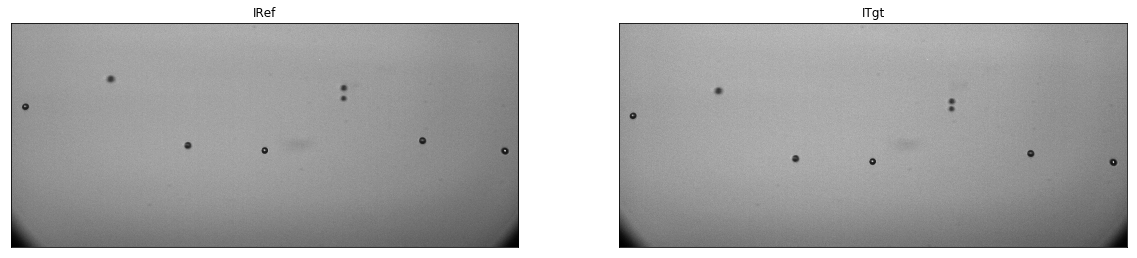

In [3]:
im16 = cv2.imread('../images/DispenserOpt_00097_2016-10-31_14.03.19.png', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# First make 2D by slicing out one channel
if len(im16.shape) == 3:
    im16 = im16[:,:,1]

# if 16bit, convert to 8bit
if im16.dtype.name.find('16') >= 0:
    im8 = bu.convert16BitTo8Bit(im16)
else:
    im8 = im16

# now subimage into ref and tgt
if (im8.shape[0] == 2*frameHeight_px):
    ITgt = im8[frameHeight_px+rMin:frameHeight_px+rMax:rStep,cMin:cMax:cStep]

IRef = im8[rMin:rMax:rStep,cMin:cMax:cStep]

util.plot_imgs([(IRef, 'IRef'), (ITgt, 'ITgt')], max_cols = 2)

### Preprocess and find blobs in Ref image

There are 24 region properties found:
(286.81081081081084, 502.3009009009009)
(330.92697768762679, 1676.7809330628804)
(383.11650485436894, 1675.995145631068)
(426.70549738219893, 72.540575916230367)
(597.09090909090912, 2073.4508599508599)
(621.03472222222217, 891.53472222222217)
(646.51668891855809, 1278.5327102803737)
(649.55102040816325, 2488.9408163265307)
(1020.0, 0.0)
(1023.0, 0.0)
(1042.9000000000001, 0.20000000000000001)
(1039.5, 2559.0)
(1130.6296296296296, 89.222222222222229)
(1130.7, 2453.0)
(1130.6818181818182, 2469.0)
(1130.8888888888889, 2494.7777777777778)
(1131.0, 67.0)
(1131.0, 71.0)
(1131.0, 74.5)
(1131.0, 77.5)
(1131.0, 103.0)
(1131.0, 113.0)
(1131.0, 821.5)
(1131.0, 2483.5)


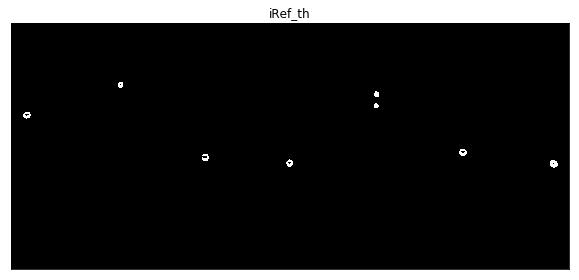

In [4]:
# Ref image processing
#---------------------
# Preprocess and binarize reference image
#iRef_th = bu.preprocAndBinarizeImg(iRef, blurKernelSize, tophatKernalSize, minThVal, maxThVal, thresholdType)
iRef_th = bu.simplePreProcAndBinarize(IRef)

# Find, label and size up the blobs
labelArrRef = measure.label(iRef_th)

# Measure properties of labeled image regions.
#  http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
RegPropsRef = measure.regionprops(labelArrRef)

numBlobsRef = len(RegPropsRef)
print("There are %d region properties found:" % (numBlobsRef))
      
for i in range(numBlobsRef):
    print(RegPropsRef[i].centroid)

blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

util.plot_imgs([(iRef_th, 'iRef_th')], max_cols = 2)

### What did we find? Filter out according to circTh, minSzInPx, maxSzInPx

In [30]:
# Blob centroids after particle filter
FiltIdxRef, numGoodBlobsRef = bu.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)
print("numGoodBlobsRef: %d" % (numGoodBlobsRef))

numGoodBlobsRef: 8


In [28]:
# Good blob indices are 0:numGoodBlobs-1 and bad blob indices numGoodBlobs+1:-1
FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]

blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]

print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsRef), len(RegPropsRefFilt)))


# of Initial ref blobs = 24, # blobs after pruning = 8


### Now process the Target image...

# of Initial ref blobs = 20, # blobs after pruning = 8


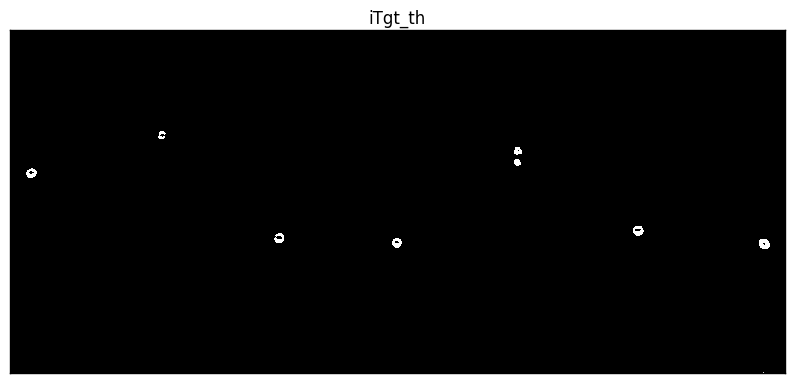

In [33]:
iTgt_th = bu.simplePreProcAndBinarize(ITgt)
labelArrTgt = measure.label(iTgt_th)
RegPropsTgt = measure.regionprops(labelArrTgt)
numBlobsTgt = len(RegPropsTgt)
blobCentroidsTgt = np.array([RegPropsTgt[i].centroid for i in range(numBlobsTgt)])
FiltIdxTgt, numGoodBlobsTgt = bu.pruneBlobs(RegPropsTgt, circTh, minSzInPx, maxSzInPx)
FiltIdxTgt = FiltIdxTgt[0:numGoodBlobsTgt]
blobCentFiltTgt = blobCentroidsTgt[FiltIdxTgt[0:numGoodBlobsTgt]]
RegPropsTgtFilt = [RegPropsTgt[i] for i in FiltIdxTgt[0:numGoodBlobsTgt]]
print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsTgt), len(RegPropsTgtFilt)))
util.plot_imgs([(iTgt_th, 'iTgt_th')], max_cols = 2)